# Úkol č. 1 - vizualizace dat a web scraping (do 11. října)

  * V rámci tohoto úkolu musíte stáhnout dat z webu (tzv. _web scraping_, velmi základní) a následně data zpracovat a vizualizovat.
  * Cílem bude stáhnout data ze serveru https://www.psp.cz/sqw/hlasovani.sqw?o=8 týkající hlasování současné poslanecké sněmovny, uložit tato data v tabulkovém formátu a pak vymyslet vizualizace a zobrazení dat, které umožní orientaci v těchto datech a zvýrazní zajímavé informace a zobrazit přehledně časový vývoj různých veličin.
 
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Data

 * Měli byste stáhnout data ze všech hlasování současné poslanecké sněmovny (tj. od voleb v roce 2017) a to až na úroveň jednotlivých poslanců. 
 * Data by měla obsahovat i stručný popis toho, o jaké hlasování šlo.

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Strojově stáhněte data a uložte je do vhodného formátu, který se Vám bude dále dobře zpracovávat. 
  * **I když nemusíte mít sněmovnu rádi, snažte se nezahltit server a mezi požadavky na stránku mějte alespoň vteřinu mezeru.**
  * V druhé části Vašeho Jupyter notebooku pracujte se staženými daty v souborech, které jsou výsledkem Vašeho stahovacího skriptu (aby opravující nemusel spouštět stahování z webu).
  * S využitím vybraných nástrojů zpracujte data a vymyslete vizualizace a grafy, aby bylo vidět následující:
    * Odchody a přeběhnutí poslanců mezi jednotlivými stranami.
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.
    * Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.
    * Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.).
  * Najděte jednotlivé poslance, kteří se nejvíce shodují při svém hlasování či kteří mají co nejpodobnější účast na hlasování.
  * Zkuste rozlišit v datech důležitá hlasování a zpracujte vizualizace (také) pro ně.
  * Zkuste najít hlasování, kde poslanci hlasovali nejvíce jinak, než obvykle.
  
## Tipy a triky
  * Balíčky iportujte na začátku notebooku (příp. na začátku scrapovací a pak na začátku vizualizační části).
  * Využívejte markdown buňky (jako je ta, ve které je tento text) a naspisy, abyste usnadnily orientaci opravující(mu).
  * Pečlivě si vybírejte grafy a vizualizace, aby co nejlépe vyjádřily to, co vyjádřit chcete. Doporučuji projít si pro inspiraci alespoň galerie balíčků `matplotlib` a `seaborn`.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook (příp. doplněn skripty), ale i soubor(y) se staženými daty (ať opravující nemusí stahovat data).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

# Web crawl a príprava dát
Stiahnutie dát  schôdzok a hlasovaní s ich popismi web crawlom

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import pprint
import numpy as np

In [ ]:
url = 'https://www.psp.cz/sqw/hlasovani.sqw?o=8'

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table')
meetings = []
for tr in table.findAll('tr'):
    try:
        meetings.append(int(tr.find('td').find('a')['href'][tr.find('td').find('a')['href'].rfind('=')+1:]))
    except:
        pass

In [ ]:
def get_voting_urls(url):
    urls = []
    numbers = []
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    trs = soup.find('table').findAll('tr')
    for tr in range(len(trs) - 1):
        tds = trs[tr + 1].findAll('td')
        urls.append('https://www.psp.cz/sqw/' + tds[1].find('a')['href'])
        numbers.append(tds[1].find('a').contents[0])
    return urls, numbers

In [ ]:
def get_votes(url, meeting, voting_number):
    print(f'Parsing meeting {meeting} with voting number {voting_number}')
    votes = []
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    main_content = soup.find(id='main-content')
    parties_soup = main_content.findAll('h2')
    if len(parties_soup) < 3:
        return []
    uls = main_content.findAll('ul')
    parties_soup.pop(-1)
    parties_soup.pop(0)
    for party_soup, ul in zip(parties_soup, uls):
        party = party_soup.find('span').contents[0].split(' ')[0]
        li = ul.findAll('li')
        for representative in li:
            dict_tmp = {'Schůze': meeting, 'Č. hl.': voting_number, 'Klub': party, 'Poslanec': representative.find('a').contents[0], 'Hlas': representative.find('span').contents[0]}
            votes.append(dict_tmp)
    return votes

In [ ]:
descriptions = {}
meetings_data = pd.DataFrame()
for meeting in meetings:
    url = "https://www.psp.cz/sqw/hl.sqw?o=8&s=" + str(meeting)
    descriptions[meeting] = {}
    votings_data_list = []
    
    response = requests.get(url)
    soup = soup = BeautifulSoup(response.text, 'html.parser')
    main_data = soup.find(id='main-content')
    ahrefs = main_data.findAll('a')
    bolds = main_data.findAll('b')

    first = True
    for bold in bolds:
        if first:
            descriptions[meeting][0] = bold.find('i').contents[0]
            first = False
        else:
            descriptions[meeting][int(bold.contents[0][:bold.contents[0].find('.')])] = bold.contents[0][bold.contents[0].find('.') + 2:]
    
    i = 1
    meetings_data_tmp = pd.DataFrame()
    while True:
        try:
            table_url = "https://www.psp.cz/sqw/phlasa.sqw?o=8&s=" + str(meeting) + "&pg=" + str(i)
            if meetings_data_tmp.empty:
                meetings_data_tmp = pd.read_html(table_url, encoding='latin2')[0]
            else:
                meetings_data_tmp = pd.concat([meetings_data_tmp, pd.read_html(table_url, encoding='latin2')[0]], ignore_index=True)
            
            voting_urls, voting_numbers = get_voting_urls(table_url)            
            for voting_url, voting_number in zip(voting_urls, voting_numbers):
                votings_data_list = votings_data_list + get_votes(voting_url, meeting, voting_number)
            
            i += 1
        except:
            break
    
    meetings_data_tmp['Bod'] = meetings_data_tmp['Bod'].fillna(0)
    meetings_data_tmp['Popis'] = meetings_data_tmp.apply(lambda x: descriptions[meeting][int(x['Bod'])], axis=1)
    votings_data = pd.DataFrame(votings_data_list)
    votings_data.to_csv(f'data/schuzka_{meeting}.csv')
    
    if meetings_data.empty:
        meetings_data = meetings_data_tmp.copy()
    else:
        meetings_data = pd.concat([meetings_data, meetings_data_tmp], ignore_index=True)
    time.sleep(1)
meetings_data = meetings_data[['Schůze', 'Č. hl.', 'Bod', 'Název', 'Popis', 'Datum', 'Výsledek']]
meetings_data.to_csv("data/meetings_data.csv")

In [ ]:
party_votes_data = []
for meeting in votes_data['Schůze'].unique():
    meeting_df = votes_data.loc[votes_data['Schůze'] == meeting]
    for voting in meeting_df['Č. hl.'].unique():
        voting_df = meeting_df.loc[meeting_df['Č. hl.'] == voting]
        for party in votes_data.Klub.unique():
            votings_of_party = voting_df.loc[voting_df['Klub'] == party]
            #print(Counter(votings_of_party['Hlas']))
            x = Counter(votings_of_party['Hlas'])
            x['Schůze']= meeting
            x['Č. hl.'] = voting
            x['Klub'] = party
            x['Total'] = sum(Counter(votings_of_party['Hlas']).values())
            party_votes_data.append(x)
parties_votes_df = pd.DataFrame(party_votes_data)
parties_votes_df = parties_votes_df.fillna(0)
parties_votes_df.to_csv('data/parties_votes_data.csv')
parties_votes_df = parties_votes_df[(parties_votes_df['Total'] != 0)&(parties_votes_df['A'] + parties_votes_df['N'] + parties_votes_df['Z'] != 0)]

# Zobrazenie dát

## Import a načítanie dát

In [1]:
import matplotlib.pyplot as plt # takto se matplotlib standardně importuje
import matplotlib
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
# bez násl. řádku někdy nefunguje vykreslování grafů v Jupyter noteboocích

%matplotlib inline 
matplotlib.style.use('ggplot')

In [2]:
votes_data = pd.read_csv('data/schuzka_1.csv')
for i in range(62):
    if i != 1:
        try:
            x = pd.read_csv(f'data/schuzka_{i}.csv')
            votes_data = pd.concat([votes_data, x], ignore_index=True)
        except:
            pass
votes_data.drop('Unnamed: 0', axis=1, inplace=True)
new_parties_df = pd.read_csv('data/parties_votes_data.csv').drop(columns=['Unnamed: 0'])
new_parties_df.drop(columns=['A', 'Z', '0', 'Total', 'M', 'N'], inplace=True)
parties_votes_df = pd.read_csv('data/parties_votes_data.csv').drop(columns=['Unnamed: 0'])
meetings_data = pd.read_csv('data/meetings_data.csv')

## Preview stiahnutých dát

In [3]:
display(meetings_data.head())
display(votes_data.head())

,Unnamed: 0,Schůze,Č. hl.,Bod,Název,Popis,Datum,Výsledek
0,0,1,1,3.0,Inf. o ustavení volební komise PS a volbě členů,Informace o ustavení volební komise Poslanecké...,20. 11. 2017 13:53,Přijato (zmatečné)
1,1,1,2,3.0,Inf. o ustavení volební komise PS a volbě členů,Informace o ustavení volební komise Poslanecké...,20. 11. 2017 13:53,Přijato
2,2,1,3,0.0,Procedurální hlasování,Procedurální hlasování,20. 11. 2017 14:47,Zamítnuto
3,3,1,4,4.0,Náv.na stanovení počtu čl. MIV,Návrh na zřízení mandátového a imunitního výbo...,20. 11. 2017 15:39,Zamítnuto
4,4,1,5,4.0,Náv.na stanovení počtu čl. MIV,Návrh na zřízení mandátového a imunitního výbo...,20. 11. 2017 15:39,Přijato


,Schůze,Č. hl.,Klub,Poslanec,Hlas
0,1,1,ANO,Věra Adámková,A
1,1,1,ANO,Andrej Babiš,A
2,1,1,ANO,Andrea Babišová,A
3,1,1,ANO,Margita Balaštíková,A
4,1,1,ANO,Josef Bělica,A


## Prestupy a odchody poslancov zo strán
V zobrazenej tabubľke sú vypísané odchody poslancov z jednotlivých strán, v prípade, že poslanec prestúpil, je vypísané odkiaľ kam.
Graf zobrazuje počty poslancov, ktorí zo strán odišli, resp. prestúpil do nich

In [4]:
parties_list = votes_data['Klub'].unique()
last_meeting = votes_data['Schůze'][votes_data.index[-1]]
last_voting = votes_data['Č. hl.'][votes_data.index[-1]]
number_of_votings = votes_data.shape[0]/200
traitors = []
renegades = []

for representative in votes_data.Poslanec.unique():
    votings_of_representative = votes_data.loc[votes_data['Poslanec'] == representative]
    if votings_of_representative.shape[0] != number_of_votings:
        if votings_of_representative['Schůze'][votings_of_representative.index[-1]] != last_meeting and \
        votings_of_representative['Č. hl.'][votings_of_representative.index[-1]] != last_voting:
            #print(f'Representative {representative} left the party {votings_of_representative.Klub.unique()[0]}')
            renegades.append(votings_of_representative.Klub.unique()[0])
    
    parties_of_representative = votings_of_representative.Klub.unique()
    if len(parties_of_representative) > 1:
        for i in range(len(parties_of_representative) - 1):
            print(f'Representative {representative} left the party {parties_of_representative[i]} for party {parties_of_representative[i+1]}')
            traitors.append((parties_of_representative[i], parties_of_representative[i+1]))
            
parties_data = {}
for x in parties_list:
    parties_data[x] = {'Odchody': 0, 'Prichody': 0}
for x in renegades:
    parties_data[x]['Odchody'] += 1
for x in traitors:
    parties_data[x[0]]['Odchody'] += 1
    parties_data[x[1]]['Prichody'] += 1

Representative Václav Klaus left the party ODS for party Nezařaz
Representative Zuzana Majerová Zahradníková left the party ODS for party Nezařaz
Representative Marian Bojko left the party SPD for party Nezařaz
Representative Tereza Hyťhová left the party SPD for party Nezařaz
Representative Ivana Nevludová left the party SPD for party Nezařaz
Representative Lubomír Volný left the party SPD for party Nezařaz
Representative Jaroslav Foldyna left the party ČSSD for party SPD
Representative Jaroslav Foldyna left the party SPD for party Nezařaz


,Odchody,Prichody
ANO,7,0
ODS,3,0
Piráti,1,0
SPD,5,1
ČSSD,3,0
KSČM,1,0
KDU-ČSL,0,0
TOP09,0,0
STAN,1,0
Nezařaz,0,7


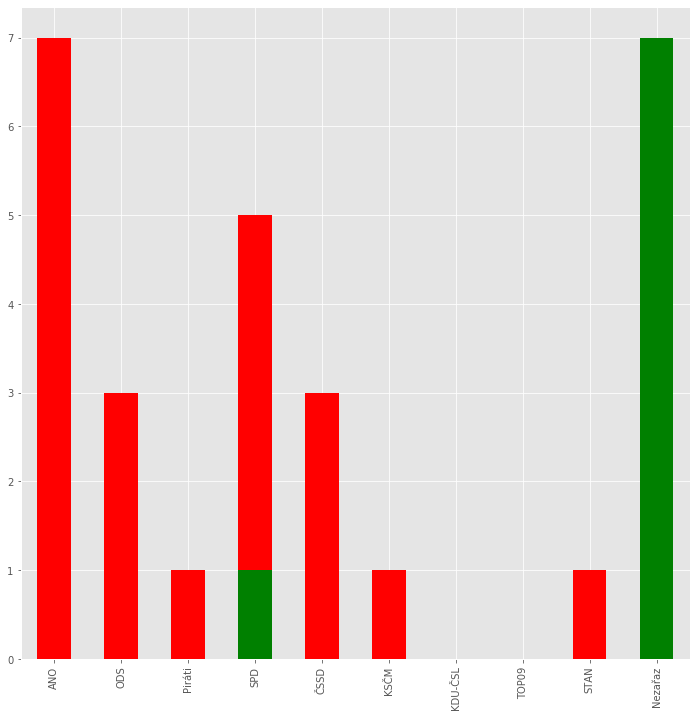

In [5]:
parties_df = pd.DataFrame(parties_data).T
display(parties_df)

plt.figure(figsize=(12,12))
parties_df['Odchody'].plot.bar(color='Red')
parties_df['Prichody'].plot.bar(color='Green')

## Dochádzka poslancov na hlasovaniach
Účasť na hlasovaní (neúčasť - poslanec bol ospravedlnení alebo neprihlásený) jednotlivých poslancov, zoradená od "najdôslednejších" poslancov k tým, ktorí v snemovni strávili najmenej času
Tabuľky zobrazujú 5 najaktívnejších (percentuálne) a 5 najneaktívnejších
Graf, okrem 20 "naj", zobrazuje aj dochádzku všetkých poslancov parlamentu - dá sa z neho vyčítať, že aspoň polovica ľudí platených z daní ľudu majú dochádzku nad 80%

In [6]:
representatives_attendance = {}
for representative in votes_data.Poslanec.unique():
    votings_of_representative = votes_data.loc[votes_data['Poslanec'] == representative]
    c = Counter(votings_of_representative['Hlas'])
    representatives_attendance[representative] = c
    representatives_attendance[representative]['Total'] = sum(c.values())

In [7]:
attendance_df = pd.DataFrame(representatives_attendance).T
attendance_df = attendance_df.fillna(0)
attendance_df['Attendance'] = (attendance_df['A'] + attendance_df['N'] + attendance_df['Z']) / attendance_df['Total'] * 100
attendance_df = attendance_df.sort_values(by=['Attendance'], ascending=False)

Best attendance:


,A,N,Z,0,M,Total,Attendance
Martin Půta,13.0,2.0,1.0,0.0,0.0,16.0,100.000000
Jiří Hlavatý,12.0,3.0,1.0,0.0,0.0,16.0,100.000000
Radek Rozvoral,5214.0,593.0,1145.0,28.0,0.0,6980.0,99.598854
Lukáš Bartoň,5337.0,673.0,940.0,27.0,3.0,6980.0,99.570201
Miloslav Rozner,5121.0,588.0,1229.0,39.0,3.0,6980.0,99.398281




Worst attendance:


,A,N,Z,0,M,Total,Attendance
Jan Hamáček,1004.0,608.0,1524.0,1669.0,2175.0,6980.0,44.928367
Martin Stropnický,295.0,131.0,76.0,150.0,558.0,1210.0,41.487603
Jana Levová,1915.0,226.0,626.0,425.0,3788.0,6980.0,39.641834
Karel Schwarzenberg,1485.0,209.0,415.0,905.0,3966.0,6980.0,30.214900
Andrej Babiš,600.0,638.0,455.0,517.0,4770.0,6980.0,24.255014


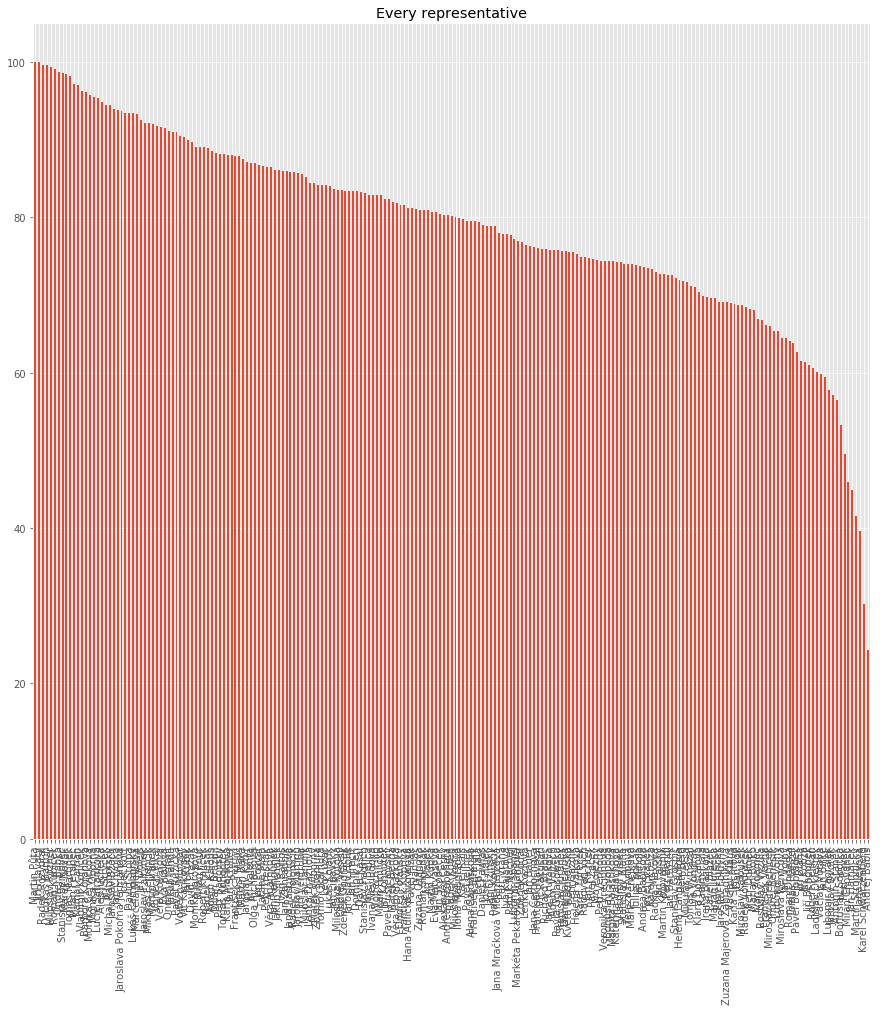

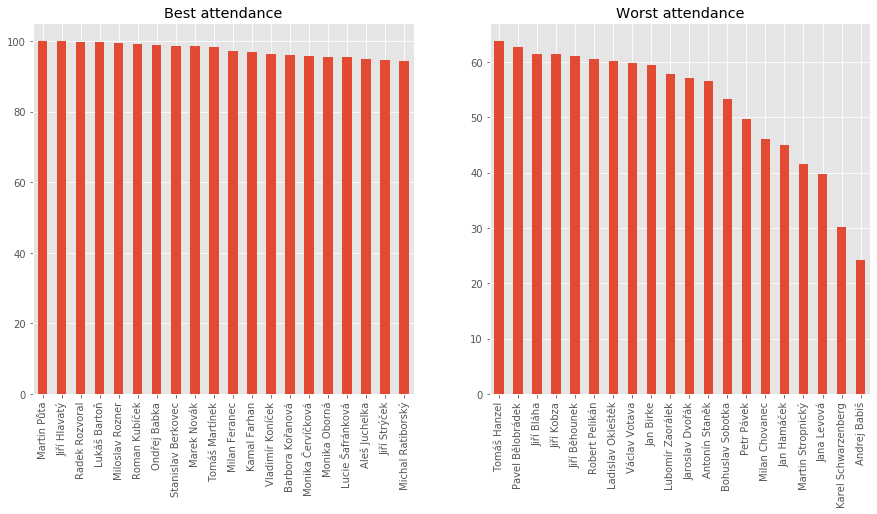

In [8]:
plt.figure(figsize=(15,15))
plt.title('Every representative')
attendance_df['Attendance'].plot.bar()
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Best attendance')
attendance_df.head(20)['Attendance'].plot.bar()
plt.subplot(222)
plt.title('Worst attendance')
attendance_df.tail(20)['Attendance'].plot.bar()
print("Best attendance:")
display(attendance_df.head(5))
print('\n')
print("Worst attendance:")
display(attendance_df.tail(5))

## Účasť strán na hlasovaniach
Tabuľka a graf zobrazujú účasť jednotlivých strán na hlasovaniach (suma všetkých členov strán), zoradené od najaktívnejšej strany po tú najmenej prítomnú

In [9]:
parties_attendance = {}
for party in votes_data.Klub.unique():
    votings_of_party = votes_data.loc[votes_data['Klub'] == party]
    c = Counter(votings_of_party['Hlas'])
    parties_attendance[party] = c
    parties_attendance[party]['Total'] = sum(c.values())
party_attendance_df = pd.DataFrame(parties_attendance).T
party_attendance_df = party_attendance_df.fillna(0)
party_attendance_df['Attendance'] = (party_attendance_df['A'] + party_attendance_df['N'] + party_attendance_df['Z']) / party_attendance_df['Total'] * 100
party_attendance_df = party_attendance_df.sort_values(by=['Attendance'], ascending=False)

,A,Z,0,N,M,Total,Attendance
Piráti,99811,19360,4170,12311,17908,153560,85.622558
ANO,208259,88355,19854,151974,75998,544440,82.394387
KSČM,38106,25722,7705,19717,13450,104700,79.794651
SPD,79327,22190,6863,9648,22956,140984,78.849373
ODS,96836,20490,12220,12682,23291,165519,78.545665
KDU-ČSL,40525,7729,4191,4035,13320,69800,74.912607
STAN,23129,5681,2716,1999,8355,41880,73.564947
ČSSD,31113,20277,9993,18300,23309,102992,67.665450
TOP09,24656,5707,3698,2548,12251,48860,67.357757
Nezařaz,9295,4760,1399,933,6878,23265,64.422953


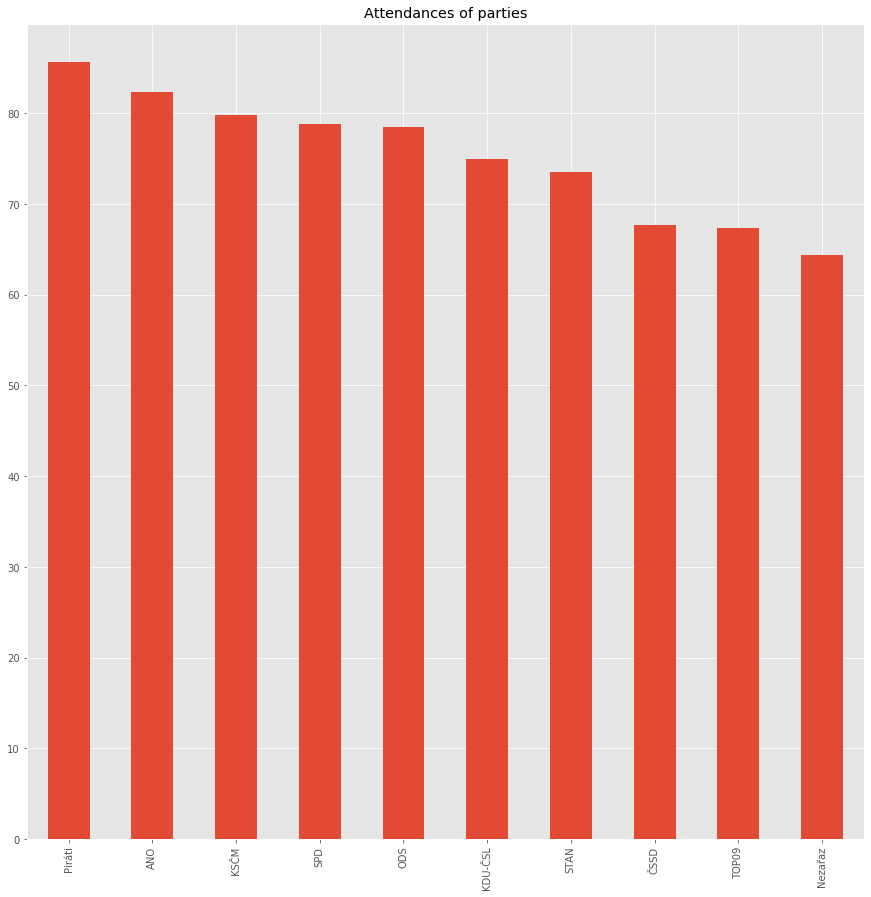

In [10]:
display(party_attendance_df)
plt.figure(figsize=(15,15))
plt.title('Attendances of parties')
party_attendance_df['Attendance'].plot.bar()

## Zhoda hlasovania jednotlivých strán
Heatmapa ukazuje zhodu, s ktorou jednotlivé strany hlasovali na rokovaniach - čím je políčko bledšie, tým väčšia zhoda medzi hlasovaním tých 2 strán

In [11]:
for party in parties_votes_df['Klub'].unique():
    new_parties_df['A'] = parties_votes_df['A'] / parties_votes_df['Total'] * 100
    new_parties_df['N'] = parties_votes_df['N'] / parties_votes_df['Total'] * 100
    new_parties_df['Z'] = parties_votes_df['Z'] / parties_votes_df['Total'] * 100
new_parties_df['Vote'] = parties_votes_df[['A', 'N', 'Z']].idxmax(1)
new_parties_df.drop(columns=['A', 'N', 'Z'], inplace=True)
new_parties_df.dropna(inplace=True)

votes_dict = {}
for party in new_parties_df['Klub'].unique():
    votes_dict[party] = {}
    for second_party in np.delete(new_parties_df['Klub'].unique(), np.where(new_parties_df['Klub'].unique() == party)):
        votes_dict[party][second_party] = 0

for meeting in new_parties_df['Schůze'].unique():
    meeting_df = new_parties_df.loc[new_parties_df['Schůze'] == meeting]
    for voting in meeting_df['Č. hl.'].unique():
        voting_df = meeting_df.loc[meeting_df['Č. hl.'] == voting]
        for vote in voting_df['Vote'].unique():
            parties_df = voting_df.loc[voting_df['Vote'] == vote]
            for party in parties_df['Klub'].unique():
                for second_party in np.delete(parties_df['Klub'].unique(), np.where(parties_df['Klub'].unique() == party)):
                    votes_dict[party][second_party] += 1

voting_stats = pd.DataFrame(votes_dict)

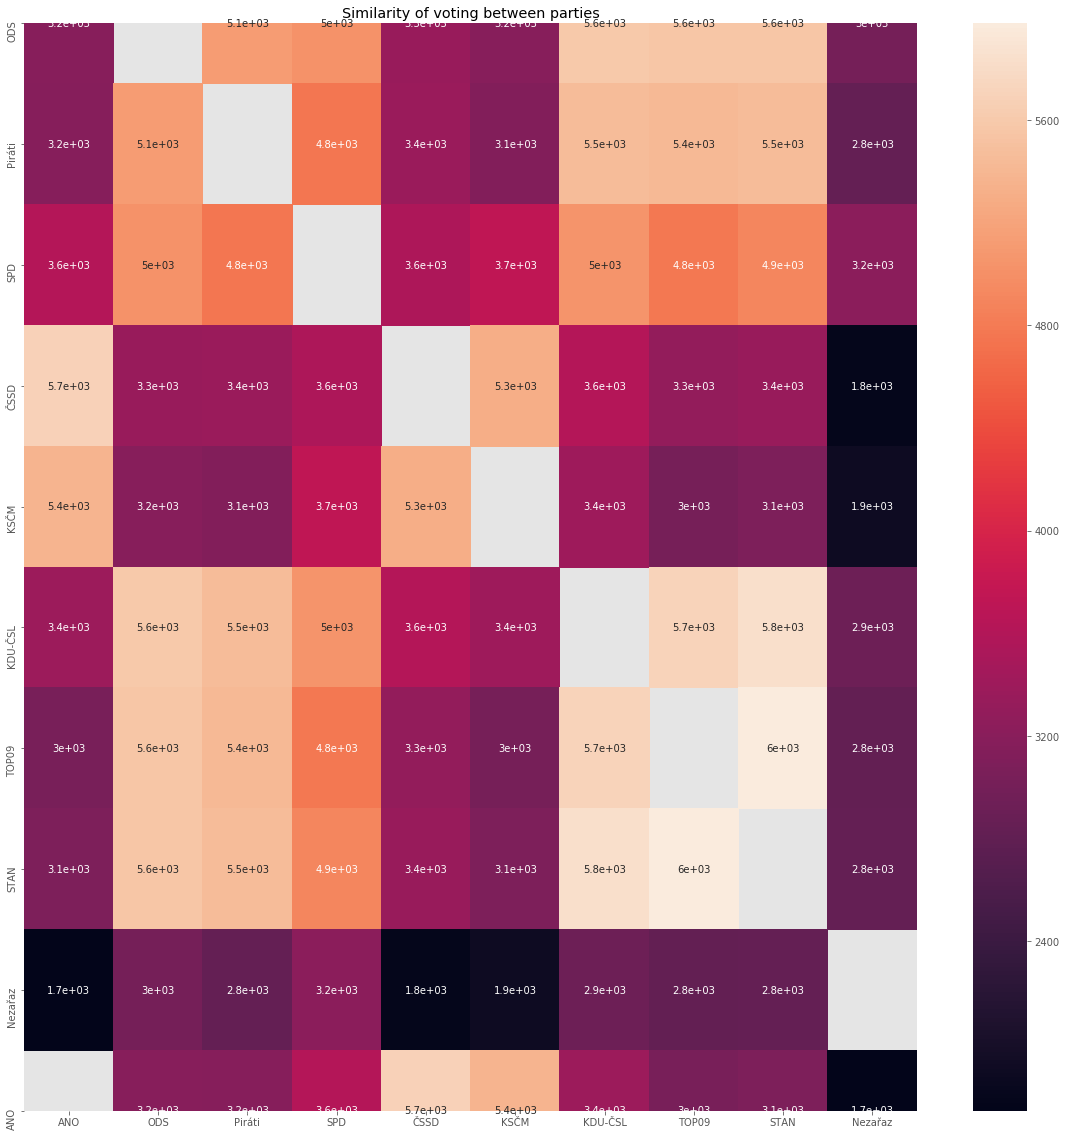

In [12]:
plt.figure(figsize=(20,20))
plt.title('Similarity of voting between parties')
sns.heatmap(voting_stats, annot=True)

## Hlasovanie jednotlivých poslancov
V grafoch je znázornených 20 najlojálnejších poslancov ku svojim stranám v parlamente a 20 najväčších "rebelov" parlamentu, voči svojej strane

In [13]:
loyalty = {}
for representative in votes_data.Poslanec.unique():
    votings_of_party = votes_data.loc[votes_data['Poslanec'] == representative][(votes_data['Hlas'] == 'A')|(votes_data['Hlas'] == 'N')|(votes_data['Hlas'] == 'Z')]
    rep_party_df = pd.merge(votings_of_party, new_parties_df[parties_votes_df['Klub'] == votings_of_party['Klub'].unique()[0]])
    if not len(np.where(rep_party_df['Hlas'] == rep_party_df['Vote'], 1, 0)):
        continue
    else:
        c = Counter(np.where(rep_party_df['Hlas'] == rep_party_df['Vote'], 1, 0))
    loyalty[representative] = c[1] / (c[1] + c[0]) * 100


/Users/mnrk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1080x1080 with 0 Axes>

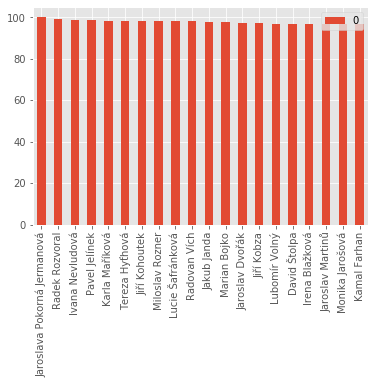

<Figure size 1080x1080 with 0 Axes>

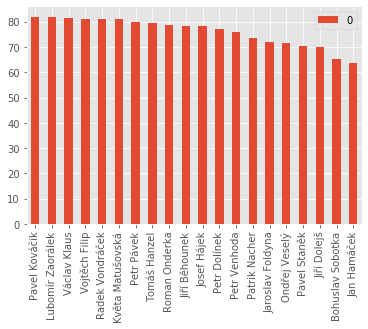

In [14]:
plt.figure(figsize=(15,15))
pd.DataFrame([loyalty]).T.sort_values(by=0, ascending=False).head(20).plot.bar()
plt.figure(figsize=(15,15))
pd.DataFrame([loyalty]).T.sort_values(by=0, ascending=False).tail(20).plot.bar()